# Deep learning A-Z : Building a RNN

<p align="justify">
This notebook is my response to the thid homework of the course called *Deep Learning A-Z™: Hands-On Artificial Neural Networks* accessible here : https://www.udemy.com/deeplearning/
</p>
<p align="justify">
In this notebook, we are going to build a LSTM RNN using keras by following instructions given on the course. This neural network will try to predict the stock price of Google. We will train this deep LSTM network on 5 years Google stock price dataset. After that, we will try to predict the stock price for 1 month (January 2017). In fact, as it is impossible to predict the stock price, we are going to focus on the trend (up or down) of the stock price.
</p>

### Imports

In [50]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### 1. Data preprocessing

In [27]:
path_train = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('__file__')))), 'ressources/Recurrent_Neural_Networks/Google_Stock_Price_Train.csv')
dataset = pd.read_csv(path_train)
dataset.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


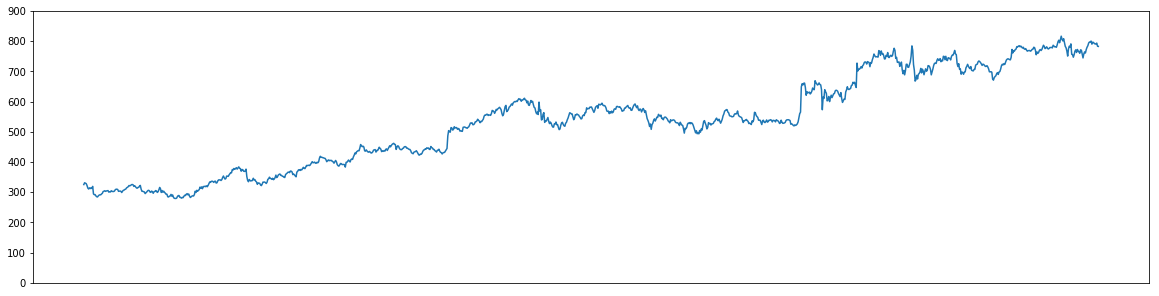

In [3]:
fig = plt.figure(figsize=(20,5))
plt.plot(dataset['Date'], dataset['Open'])
plt.yticks([k*100 for k in range(10)])
plt.xticks([])
plt.show()

In [28]:
# select "Open" column
training_set = dataset.iloc[:, 1:2].values
training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

Normalisation is better than standardization for a RNN in general an especially for RNN with a sigmoid activation function for output layer. 

In [29]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

60 time steps are the past information on which the RNN will learn to produce an output. For exemple, 20 time steps are probably not enough to capture some trend. So we are going to look a the past 3 months to predict the value for each day.

In [30]:
# creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []

for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train

array([[0.08581368, 0.09701243, 0.09433366, ..., 0.07846566, 0.08034452,
        0.08497656],
       [0.09701243, 0.09433366, 0.09156187, ..., 0.08034452, 0.08497656,
        0.08627874],
       [0.09433366, 0.09156187, 0.07984225, ..., 0.08497656, 0.08627874,
        0.08471612],
       ...,
       [0.92106928, 0.92438053, 0.93048218, ..., 0.95475854, 0.95204256,
        0.95163331],
       [0.92438053, 0.93048218, 0.9299055 , ..., 0.95204256, 0.95163331,
        0.95725128],
       [0.93048218, 0.9299055 , 0.93113327, ..., 0.95163331, 0.95725128,
        0.93796041]])

From documentation (https://keras.io/layers/recurrent/#rnn), we can see that input shape must be a 3D tensor with shape (batch_size, timesteps, input_dim).

In [34]:
# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1198, 60, 1)

X_train is now a 3 dimmentionnal structure !

### 2. Building the RNN

In [12]:
# Initializing the RNN
regressor = Sequential()

In [13]:
# Adding the first LSTM layer and some dropout regularization
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

- *units* is the number of neurons. Capturing stock price is complicated so we need a lot of neurons.
- *return_sequences* must be set as TRUE if it is a stacked LSTM network with more than 1 layer

In [16]:
# Adding other LSTM layers
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

In [17]:
# Adding output layer
regressor.add(Dense(units=1))

In [19]:
# Compile RNN
regressor.compile(optimizer='adam', loss='mse')

- *optimizer* rmsprop can be a good choice for RNN, just as adam (always good performances).
- *loss* 'mse' (min_squared_error) is choosed because this is a regression problem.

In [35]:
# Train the RNN
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
1198/1198 [==============================] - 14s 12ms/step - loss: 0.0519
Epoch 2/100
1198/1198 [==============================] - 11s 9ms/step - loss: 0.0060
Epoch 3/100
1198/1198 [==============================] - 11s 9ms/step - loss: 0.0065
Epoch 4/100
1198/1198 [==============================] - 11s 9ms/step - loss: 0.0054
Epoch 5/100
1198/1198 [==============================] - 13s 11ms/step - loss: 0.0048
Epoch 6/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0047
Epoch 7/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0043
Epoch 8/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0050
Epoch 9/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0042
Epoch 10/100
1198/1198 [==============================] - 13s 11ms/step - loss: 0.0041
Epoch 11/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0043
Epoch 12/100
1198/1198 [==============================]

### 3. Make prediction and visualising results

In [37]:
# Getting the real stock price of 1rst month of 2017
path_test = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('__file__')))), 'ressources/Recurrent_Neural_Networks/Google_Stock_Price_Test.csv')
dataset_test = pd.read_csv(path_test)
real_stock_price = dataset_test.iloc[:, 1:2].values
real_stock_price

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ],
       [807.86],
       [805.  ],
       [807.14],
       [807.48],
       [807.08],
       [805.81],
       [805.12],
       [806.91],
       [807.25],
       [822.3 ],
       [829.62],
       [837.81],
       [834.71],
       [814.66],
       [796.86]])

In [45]:
# Getting the predicted stock price of 1rst month of 2017
dataset_total = pd.concat((dataset['Open'], dataset_test['Open']), 0)
inputs = dataset_total[len(dataset_total)-len(dataset_test)-60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test

array([[0.9299055 , 0.93113327, 0.92750577, ..., 0.95725128, 0.93796041,
        0.93688146],
       [0.93113327, 0.92750577, 0.94415507, ..., 0.93796041, 0.93688146,
        0.92955205],
       [0.92750577, 0.94415507, 0.93876032, ..., 0.93688146, 0.92955205,
        0.94731751],
       ...,
       [0.96054394, 0.9371419 , 0.92841729, ..., 1.01045465, 1.02407173,
        1.03930724],
       [0.9371419 , 0.92841729, 0.90804747, ..., 1.02407173, 1.03930724,
        1.03354044],
       [0.92841729, 0.90804747, 0.8771858 , ..., 1.03930724, 1.03354044,
        0.99624228]])

In [46]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(20, 60, 1)

In [47]:
# Make prediction
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price

array([[791.1729 ],
       [788.14624],
       [787.7471 ],
       [789.1623 ],
       [792.77637],
       [799.0552 ],
       [805.28674],
       [808.32007],
       [808.636  ],
       [807.7663 ],
       [806.8744 ],
       [806.29803],
       [806.0867 ],
       [806.6601 ],
       [807.7691 ],
       [812.2032 ],
       [819.4432 ],
       [827.65686],
       [832.7415 ],
       [829.37683]], dtype=float32)

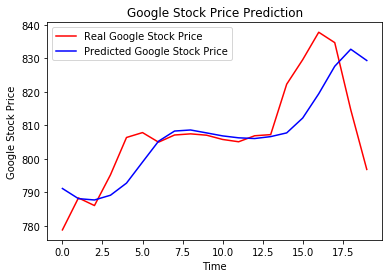

In [48]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [51]:
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
rmse

11.723204062959384